<center><h1> Build and track our portfolio based on our trades.<h1></center>

### Doesn't have any concept of buy and sell just yet.  only that a position is bought and held

In [111]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import pylab
import requests as rq
import matplotlib
import numpy as np
from helper_scripts import *
from IPython.display import HTML
from datetime import datetime
from ipywidgets import interact, interact_manual
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## We load the data into a pandas dataframe and Render as a nicer table

In [2]:
trade_data = pd.read_csv('data/trades.csv', delimiter=',')
h = get_table_html(trade_data)
HTML(h)

,tickers,dates,price,amounts,commission,currency,market,company name,type,owner,type.1,junior/developer/producer,main commodity,secondary commodity,principle country,principle region,juridication risk,U,Au,Ag,Sn,Cu,Ni,REs,Zn,Pb,Li,Co,graphite,other,asset 1 mine,asset 1 jurisdiction,asset 2 mine,asset 1 jurisdiction.1
0,BMN.AX,2020-12-14,0.079000,8200,19.950000,AUD,ASX,Bannerman Energy,stock,SDH,commodity,developer,U,nan,Namibia,nan,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,BOE.AX,2020-12-14,0.092000,5400,19.950000,AUD,ASX,Boss Energy,stock,SDH,commodity,snr developer,U,nan,Australia,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,VMY.AX,2020-12-14,0.061000,10000,19.950000,AUD,ASX,Vimy Resources,stock,SDH,commodity,developer,U,nan,Australia,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,ORI.AX,2021-01-01,15.130000,51,19.950000,AUD,ASX,Orica,stock,TMB,resources,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,AGE.AX,2021-01-07,0.014000,50000,19.950000,AUD,ASX,Alligator Energy,stock,SDH,commodity,exploration,U,nan,Australia,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,PDN.AX,2021-01-07,0.315000,6000,19.950000,AUD,ASX,Paladin Energy,stock,SDH,commodity,snr developer,U,nan,Namibia,nan,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,URA,2021-01-14,16.200000,100,19.950000,USD,US,Global X Uranium ETF,ETF,SDH,commodity,nan,U,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,NXE,2021-01-15,2.740000,410,19.950000,USD,US,Nexgen Energy,stock,SDH,commodity,developer,U,nan,USA,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,VMY.AX,2021-01-15,0.092000,10000,19.950000,AUD,ASX,Vimy Resources,stock,SDH,commodity,developer,U,nan,Australia,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,WGX.AX,2021-01-24,2.090000,2644,19.950000,AUD,ASX,Westgold Resources,stock,TMB,commodity,producer,Au,nan,Australia,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [3]:
quotes = get_quotes(trade_data)

- EQX.V: No data found, symbol may be delisted             


<!-- <div class="alert alert-danger" role="alert">
  ^^^ We  can see a few missing. Need to fix these later. 
</div> -->

In [4]:
@interact()
def make_plot(ticker=trade_data['tickers']):

    ii = list(trade_data['tickers']).index(ticker)
    candlestick = go.Candlestick(x=quotes[ii].index,
                                open=quotes[ii]['Open'],
                                high=quotes[ii]['High'],
                                low=quotes[ii]['Low'],
                                close=quotes[ii]['Close'])

    fig = go.Figure(data=[candlestick])
    fig.update_layout(xaxis_rangeslider_visible=False,
                     title=trade_data['tickers'][ii],
                     template='plotly_dark',
                     width=1600, height=800)

    fig.show()

interactive(children=(Dropdown(description='ticker', options=('BMN.AX', 'BOE.AX', 'VMY.AX', 'ORI.AX', 'AGE.AX'…

## Now we need to generate our port folio based on the ticker data.  Dealing with datetimes is always painful

In [5]:
portfolio = generate_portfolio(trade_data, quotes)
portfolio.describe()

tickers,AFM.V,AG,AGE.AX,BDC.AX,BEM.AX,BGL.AX,BMN.AX,BOE.AX,BUX.AX,CCJ,...,SRZ.AX,SUP.AX,SVL.AX,TMZ.AX,URA,URNM,UUUU,VMY.AX,WGX.AX,Total
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,...,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,577.192118,1094.230645,1080.640405,655.586210,232.321429,1119.014776,2328.003940,2492.423659,274.926109,1177.558616,...,1154.187204,941.502471,1329.064022,999.605912,1656.673977,957.490764,2210.772167,3303.231536,4472.658101,69297.064839
std,1225.046171,1067.543027,918.571908,488.594487,155.143381,1100.288749,1320.129598,1644.549704,218.672003,955.567750,...,1248.957881,757.269943,962.947509,762.104852,723.607145,756.420552,1657.064358,1524.683699,2310.864312,47153.476415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,631.399997,421.200009,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000007,0.000000,1582.600012
25%,0.000000,0.000000,650.000013,0.000000,0.000000,0.000000,1065.999961,593.999997,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1595.659494,0.000000,0.000000,1749.999970,5089.699874,17911.070948
50%,0.000000,1277.984924,749.999983,994.000033,299.999993,1215.000004,2365.999913,2957.999915,350.000001,1783.099899,...,0.000000,1449.999958,1759.999990,1439.999968,1902.805138,1424.499989,3185.499978,3839.999914,5499.519798,81138.846616
75%,0.000000,2269.440033,1549.999975,1021.999985,350.000001,1391.250014,3184.999946,3468.000036,399.999991,2108.149996,...,2400.000021,1550.000012,2039.999962,1620.000064,2119.555092,1567.124987,3516.125005,4320.000172,5843.240101,109721.295856
max,3799.999952,2678.400055,4070.000052,1119.999975,462.500006,4059.999943,5372.499909,6372.000253,750.000030,2379.299908,...,3400.000185,1800.000072,2640.000105,1980.000079,2360.277557,1770.750046,4191.749978,6239.999861,6345.600252,138084.969894


## To calculate our P/L  we need to keep a daily cost basis.  our P/L is the difference between these data.   ... I think

In [183]:
END = datetime.now()
_dates = []

for date in trade_data['dates']:
    _dates.append(datetime.strptime(date, '%Y-%m-%d').date())

date_range = pd.date_range(start=min(_dates), end=END, freq='D')
dict_profit = {}

# for each trade, insert, amount price
for ticker in trade_data['tickers'].unique():
    profit = None
    profit = date_range.to_frame()
    profit['tickers'] = np.nan
    profit['prices'] = np.nan
    profit['amounts'] = np.nan

    frames = [profit]
    
    for ii, date in enumerate(trade_data[trade_data['tickers']==ticker]['dates']):
        #calculate our cost based on our purchases
        profit.loc[date, 'tickers'] = ticker
        profit.loc[date, 'prices'] = trade_data[trade_data['tickers']==ticker]['price'].iloc[ii]
        profit.loc[date, 'amounts'] = trade_data[trade_data['tickers']==ticker]['amounts'].cumsum().iloc[ii]
        profit.loc[date, 'costs'] = trade_data[trade_data['tickers']==ticker]['amounts'].cumsum().iloc[ii] * trade_data[trade_data['tickers']==ticker]['price'].iloc[ii]
        
        
    profit.fillna(method='ffill', inplace=True)
    profit.drop(profit.columns[0], axis=1, inplace=True)
    
    frames = [profit, portfolio[ticker]]
    result = pd.concat(frames, axis=1)
    result.columns = ['tickers', 'prices', 'amounts', 'costs', 'value']
    
    result['pnl'] = result['value'] - result['costs']
    result['pnl_pct'] = (result['value'] - result['costs']) / result['costs']      
        
    dict_profit[ticker] = result.copy()

In [185]:
@interact
def plot_profit(ticker=trade_data['tickers'].unique()):
    
    fig = px.line(dict_profit[ticker][['costs',  'value', 'pnl', 'pnl_pct']], width=1600, height=800, log_y=False)
    fig.update_layout(xaxis_rangeslider_visible=False,
                     title='Portfolio Value',
                     template='plotly_dark')
    fig.show()

interactive(children=(Dropdown(description='ticker', options=('BMN.AX', 'BOE.AX', 'VMY.AX', 'ORI.AX', 'AGE.AX'…

In [199]:
@interact
def plot_profit(ticker=trade_data['tickers'].unique()):
    
    fig = px.line(dict_profit[ticker][['pnl_pct']] *100, width=1600, height=800, log_y=False)
    fig.update_layout(xaxis_rangeslider_visible=False,
                     title=f'Portfolio Value {ticker}',
                     template='plotly_dark')
    fig.show()

interactive(children=(Dropdown(description='ticker', options=('BMN.AX', 'BOE.AX', 'VMY.AX', 'ORI.AX', 'AGE.AX'…

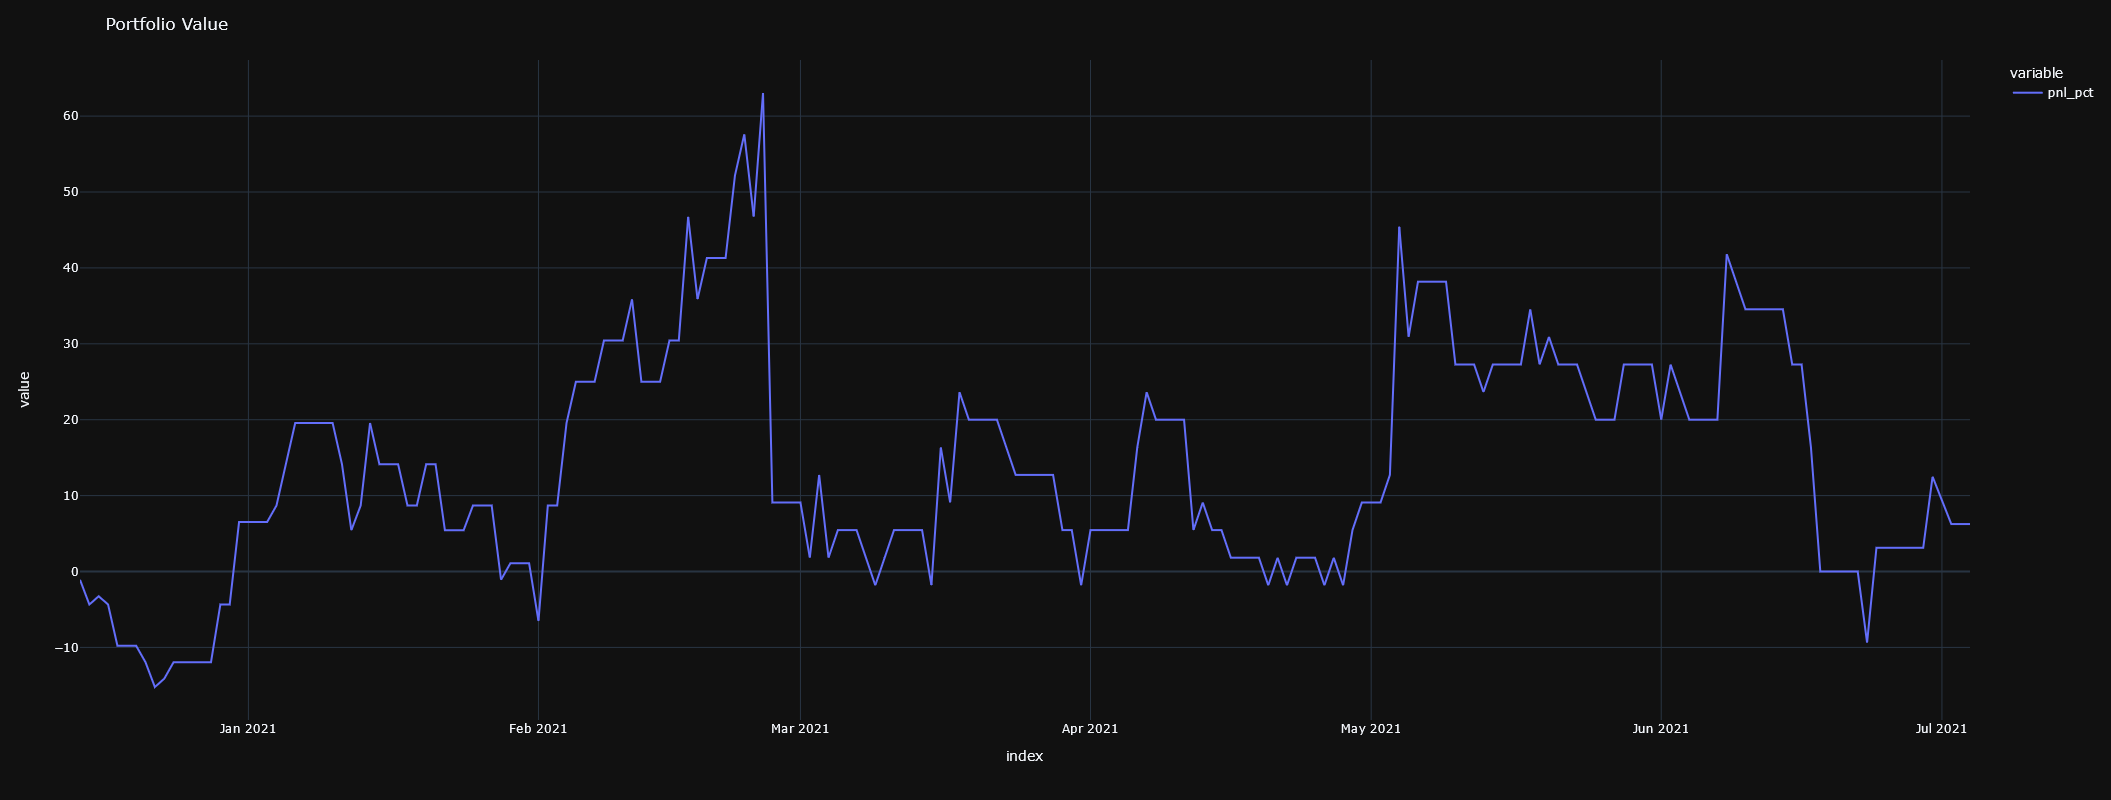

In [200]:
fig = px.line(dict_profit['BMN.AX']['pnl_pct'] *100, width=1600, height=800, log_y=False)
fig = px.line(dict_profit['BOE.AX']['pnl_pct'] *100, width=1600, height=800, log_y=False)
fig.update_layout(xaxis_rangeslider_visible=False,
                 title='Portfolio Value',
                 template='plotly_dark')

fig.show()

## Creat a new table so we can get the last pnl for each ticker

In [348]:
dash = {}
dash['ticker'] = dict_profit.keys()
dash  = pd.DataFrame.from_dict(dash)
dash.set_index('ticker', inplace=True)
dash['last_price'] = np.nan
dash['+/-'] = np.nan
dash['%'] = np.nan
dash['units_held'] = np.nan
dash['net_average_price'] = np.nan
dash['cost'] = np.nan
dash['market_value'] = np.nan
dash['day_gain'] = np.nan
dash['P&L'] = np.nan
dash['P&L_%'] = np.nan

for ticker in dash.index:
#     print(ticker)
    dash['last_price'].loc[ticker] = portfolio[ticker].iloc[-1]
    dash['+/-'].loc[ticker] = dict_profit[ticker]['prices'][-1] - dict_profit[ticker]['prices'][-2]  # Weekends will set this to 0 Stupid stonks
    dash['%'].loc[ticker] =  ((portfolio[ticker][-1] - portfolio[ticker][-1]) /  portfolio[ticker][-1]) * 100.0
    dash['units_held'].loc[ticker] = dict_profit[ticker]['amounts'][-1]
    dash['net_average_price'].loc[ticker] = dict_profit[ticker]['prices'].mean()
    dash['cost'].loc[ticker] = dict_profit[ticker]['costs'][-1]
    dash['market_value'].loc[ticker] = dict_profit[ticker]['value'][-1]
    dash['day_gain'].loc[ticker] = portfolio[ticker][-1] - portfolio[ticker][-2]  # Weekends will set this to 0 Stupid stonks
    dash['P&L'].loc[ticker] = dict_profit[ticker]['pnl'][-1]
    dash['P&L_%'].loc[ticker] = dict_profit[ticker]['pnl_pct'][-1] *100


<ipython-input-348-78b063b08700>:20: RuntimeWarning:

invalid value encountered in double_scalars



In [352]:


h = get_table_html(dash.sort_values('P&L_%', ascending=False))
HTML(h)

,last_price,+/-,%,units_held,net_average_price,cost,market_value,day_gain,P&L,P&L_%
ticker,,,,,,,,,,
BUX.AX,724.999979,0.000000,0.000000,5000.000000,0.072000,360.000000,724.999979,0.000000,364.999979,101.388883
PEN.AX,5279.999882,0.000000,0.000000,33000.000000,0.112325,3465.000000,5279.999882,0.000000,1814.999882,52.380949
GXY.AX,1894.999981,0.000000,0.000000,500.000000,2.730000,1365.000000,1894.999981,0.000000,529.999981,38.827837
POS.AX,2099.999934,0.000000,0.000000,20000.000000,0.076000,1520.000000,2099.999934,0.000000,579.999934,38.157890
FNV,3693.500137,0.000000,0.000000,25.000000,108.368000,2709.200000,3693.500137,0.000000,984.300137,36.331764
PDN.AX,6766.999936,0.000000,0.000000,13400.000000,0.360363,5025.000000,6766.999936,0.000000,1741.999936,34.666665
MRM.AX,2697.499946,0.000000,0.000000,6500.000000,0.315000,2047.500000,2697.499946,0.000000,649.999946,31.746029
URA,2134.000015,0.000000,0.000000,100.000000,16.200000,1620.000000,2134.000015,0.000000,514.000015,31.728396
SAND,3184.000015,0.000000,0.000000,400.000000,6.413000,2565.200000,3184.000015,0.000000,618.800015,24.122876


## Now we need to find our non-aud equities and convert to AUD

In [19]:
cl =trade_data['currency'].unique()  #  TODO We are converting AUD to AUD with this.  very innefficient.  but breaks if we don't do it.
# cl = cl[cl!='AUD']  # if we're in AUD don't try and convert

for currency in cl:
    cols = trade_data[trade_data['currency']==currency]['tickers']
    for ii, item in enumerate(cols.values):
        c = convert_to_aud(portfolio[item], currency)
#         print(c)
        portfolio[item] = c

In [20]:
portfolio.head()

tickers,AFM.V,AG,AGE.AX,BDC.AX,BEM.AX,BGL.AX,BMN.AX,BOE.AX,BUX.AX,CCJ,...,SRZ.AX,SUP.AX,SVL.AX,TMZ.AX,URA,URNM,UUUU,VMY.AX,WGX.AX,Total
2020-12-14,0.0,0.0,0.0,0.0,0.0,0.0,680.599974,491.399990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,610.000007,0.0,1781.999971
2020-12-15,0.0,0.0,0.0,0.0,0.0,0.0,688.799991,475.199997,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529.999994,0.0,1693.999982
2020-12-16,0.0,0.0,0.0,0.0,0.0,0.0,705.200024,480.600008,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,630.000010,0.0,1815.800042
2020-12-17,0.0,0.0,0.0,0.0,0.0,0.0,655.999985,475.199997,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,630.000010,0.0,1761.199993
2020-12-18,0.0,0.0,0.0,0.0,0.0,0.0,655.999985,448.199983,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599.999987,0.0,1704.199955


In [21]:
def write_to_excel(file='data/converted_portfolio.xls'):
    portfolio.to_excel(file)
write_to_excel()

<ipython-input-21-c985e1492964>:2: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



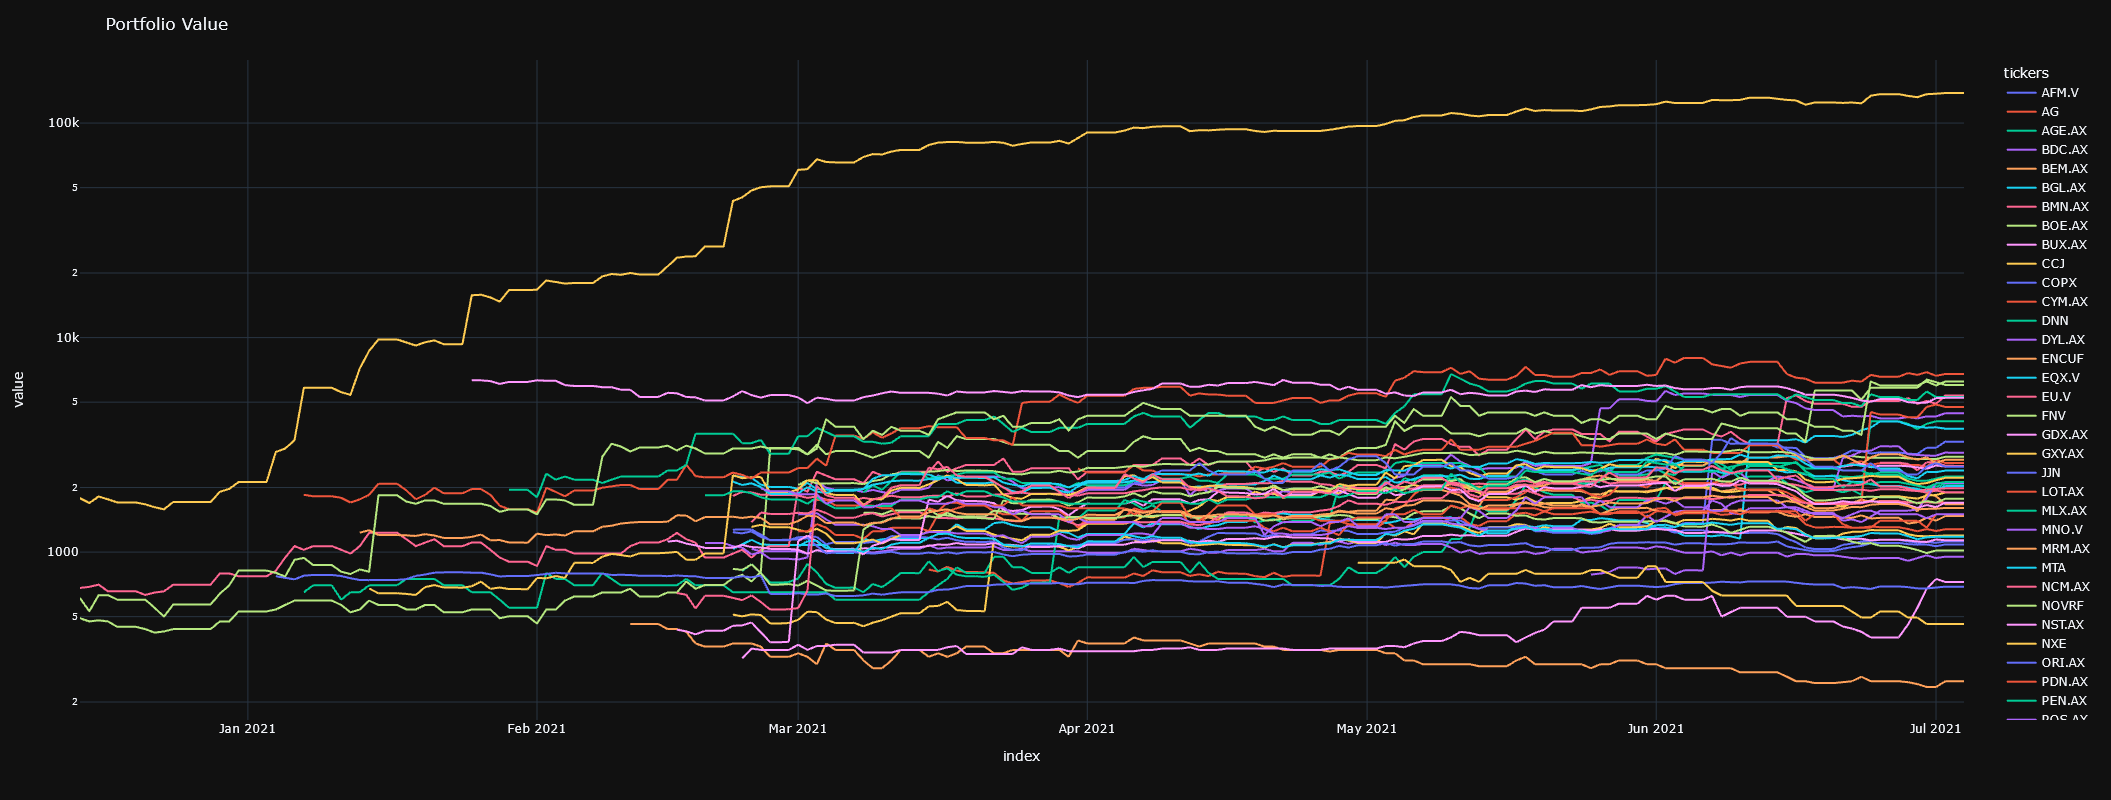

In [22]:
fig = px.line(portfolio, width=1600, height=800, log_y=True)
fig.update_layout(xaxis_rangeslider_visible=False,
                 title='Portfolio Value',
                 template='plotly_dark')
fig.show()

In [27]:
def make_pie(df):
    pylab.pie(df, labels=df.index, shadow = True, autopct='%1.1f%%', textprops={'color':"w"})

Text(0.5, 1.0, 'Market')

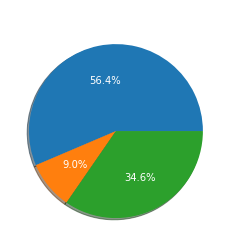

In [29]:
make_pie(trade_data.groupby(['market'] )['tickers'].count())
pylab.title('Market', c='WHITE')

In [45]:
tt = trade_data.groupby(['tickers'])['tickers'].count().sort_values(ascending=False)
tt

tickers
VMY.AX    4
DYL.AX    3
PDN.AX    3
PEN.AX    3
BMN.AX    3
BOE.AX    3
MNO.V     3
SILJ      3
SILV      3
DNN       3
AFM.V     2
AG        2
LOT.AX    2
NXE       2
CCJ       2
BGL.AX    2
UUUU      2
AGE.AX    2
SVL.AX    1
ORI.AX    1
SRZ.AX    1
SRN.AX    1
TMZ.AX    1
URA       1
SFR.AX    1
SAND      1
URNM      1
RSNVF     1
POS.AX    1
SUP.AX    1
MRM.AX    1
NST.AX    1
NOVRF     1
BDC.AX    1
BEM.AX    1
BUX.AX    1
COPX      1
CYM.AX    1
ENCUF     1
EQX.V     1
EU.V      1
FNV       1
GDX.AX    1
GXY.AX    1
JJN       1
MLX.AX    1
MTA       1
NCM.AX    1
WGX.AX    1
Name: tickers, dtype: int64

In [ ]:
@interact()
def plot_pie(day=(0, portfolio.count()[0]-1)):
    tmp = portfolio.copy()
    tmp = tmp.drop('Total', axis=1)
    vec = tmp.iloc[day].to_numpy()[:-1]
    pylab.pie(vec, labels=tmp.columns[:-1], shadow = True, autopct='%1.1f%%', textprops={'color':"w"});
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18*2, 10*2)

In [ ]:
import plotly.express as px

portfolio.corr();

fig = px.imshow(portfolio.corr(), width=1000, height=1000)
fig.update_layout(
    title= 'Pearson Correlation Coefficient')
fig.show()